# Testing with Concept Activation Vectors (TCAV) on Sensitivity Classification Examples and a ConvNet model trained on IMDB DataSet

This tutorial shows how to apply TCAV, a concept-based model interpretability algorithm, on sentiment classification task using a ConvNet model (https://captum.ai/tutorials/IMDB_TorchText_Interpret) that was trained using IMDB sensitivity dataset.

More details about the approach can be found here: https://arxiv.org/pdf/1711.11279.pdf

In order to use TCAV, we need to predefine a list of concepts that we want our predictions to be test against.

Concepts are human-understandable, high-level abstractions such as visually represented "stripes" in case of images or "positive adjective concept" such as "amazing, great, etc" in case of text. Concepts are formatted and represented as input tensors and do not need to be part of the training or test datasets.

Concepts are incorporated into the importance score computations using Concept Activation Vectors (CAVs). Traditionally, CAVs train linear classifiers and learn decision boundaries between different concepts using the activations of predefined concepts in a NN layer as inputs to the classifier that we train. The vector that is orthogonal to learnt decision boundary and is pointing towards the direction of a concept is the CAV of that concept.

TCAV measures the importance of a concept for a prediction based on the directional sensitivity (derivatives) of a concept in Neural Network (NN) layers. For a given concept and layer it is obtained by aggregating the dot product between CAV for given concept in given layer and the gradients of model predictions w.r.t. given layer output. The aggregation can be performed based on either signs or magnitudes of the directional sensitivities of concepts across multiple examples belonging to a certain class. More details about the technique can be found in above mentioned papers.

Note: Before running this tutorial, please install the spacy, numpy, scipy, sklearn, PIL, and matplotlib packages.



In [1]:
import os
import glob
import random

import torch
import torchtext
import spacy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

from torch.utils.data import DataLoader, Dataset, IterableDataset

#.... Captum imports..................
from captum.concept import TCAV
from captum.concept import Concept
from captum.concept._utils.common import concepts_to_str

from torchtext.vocab import Vocab

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset

nlp = spacy.load('en')

# fixing the seed for CAV training purposes and performing train/test split
random.seed(123)
np.random.seed(123)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Defining torchtext data `Field` so that we can load the vocabulary for IMDB dataset the way that was done to train IMDB model. 

In [3]:
TEXT = torchtext.data.Field(lower=True, tokenize='spacy')
Label = torchtext.data.LabelField(dtype = torch.float)

Reading IMDB dataset the same way we did for training sensitivity analysis model. This will help us to load correct token to embedding mapping using Glove.

In [4]:
train, _ = torchtext.datasets.IMDB.splits(text_field=TEXT,
                                              label_field=Label,
                                              train='train',
                                              test='test',
                                              path='data/aclImdb')


Loading token-to-embedding vectors from Glove and building the vocabulary using IMDB training dataset.

In [5]:
from torchtext import vocab

MAX_VOCAB_SIZE = 25_000

# If you prefer to use pre-downloaded glove vectors, you can load them with the following two command line
loaded_vectors = torchtext.vocab.Vectors('data/glove.6B.50d.txt')

TEXT.build_vocab(train, vectors=loaded_vectors, max_size=len(loaded_vectors.stoi))
TEXT.vocab.set_vectors(stoi=loaded_vectors.stoi, vectors=loaded_vectors.vectors, dim=loaded_vectors.dim)



In [6]:
print('Vocabulary Size: ', len(TEXT.vocab))

Vocabulary Size:  101513


A helper function that allows to read concept examples from an input file. We also define `const_len=7`, minimum and maximum length of tokens in text. The text is extended up to 7 tokens with padding, if it is short or is truncated up to 7 tokens if it is long.

In [7]:
def get_tensor_from_filename(filename):
    ds = torchtext.data.TabularDataset(path=filename,
                                       fields=[('text', torchtext.data.Field()),
                                               ('label', torchtext.data.Field())],
                                       format='csv')
    const_len = 7
    for concept in ds:
        concept.text = concept.text[:const_len]
        concept.text += ['pad'] * max(0, const_len - len(concept.text))
        text_indices = torch.tensor([TEXT.vocab.stoi[t] for t in concept.text], device=device)
        yield text_indices
        

The function below allows us to create a concept instance using a file path where the concepts are stored, concept name and id.

In [8]:
def assemble_concept(name, id, concepts_path="data/tcav/text-sensitivity"):
    dataset = CustomIterableDataset(get_tensor_from_filename, concepts_path)
    concept_iter = dataset_to_dataloader(dataset, batch_size=1)
    return Concept(id=id, name=name, data_iter=concept_iter)


Let's define and visualize the concepts that we'd like to explore in this tutorial.

For this tutorial we look into two concepts, `Positive Adjectives` and `Neutral`. `Positive Adjectives` concept defines a group of adjectives that convey positive emotions such as `good` or `lovely`. The `Neutral` concept spans broader domains / subjects and is distinct from the `Positive Adjectives` concept.

The concept definition and the examples describing that concepts are left up to the user.

Below we visualize examples from both `Positive Adjectives` and `Neutral` concepts. This concepts are curated for demonstration purposes. It's up to a user what to include into a concept and what not.

In [9]:
def print_concept_sample(concept_iter):
    cnt = 0
    max_print = 10
    item = next(concept_iter)
    while cnt < max_print and item is not None:
        print(' '.join([TEXT.vocab.itos[item_elem] for item_elem in item[0]]))
        item = next(concept_iter)
        cnt += 1

neutral_concept = assemble_concept('neutral', 0, concepts_path="data/tcav/text-sensitivity/neutral.csv")
positive_concept = assemble_concept('positive-adjectives', 5, \
                                    concepts_path="data/tcav/text-sensitivity/positive-adjectives.csv")


Both `Positive Adjective` and `Neutral` concepts have the same number of examples representing corresponding concept. The examples for the `Positive Adjective` concept are semi-hand curated and the context is neutralized whereas those for neutral concept are chosen randomly from Gutenberg Poem Dataset (https://github.com/google-research-datasets/poem-sentiment/blob/master/data/train.tsv)

You can consider also using Stanford Sentiment Tree Bank (SST, https://nlp.stanford.edu/sentiment/index.html) dataset with `neutral` labels. 

# Examples representing `Neutral` Concept

In [10]:
print_concept_sample(iter(neutral_concept.data_iter))

with pale blue <unk> in these peaceful
it flows so long as falls the
and that is why pad pad pad
when i peruse the conquered fame of
of inward strife for truth and <unk>
the red sword sealed their <unk> pad
and very venus of a <unk> pad
who the man pad pad pad pad
and so <unk> then a worthless <unk>
to hide the orb of <unk> every


# Examples representing `Positive Adjective` Concept

`Positive Adjectives` concept is surrounded by neutral / uninformative context. It is important to note that we positioned positive adjectives in different locations in the text. This makes concept definitions more abstract and independent of the location. Apart from that as we can see the length of the text in the concepts in fixed to 7. This is because our sensitivity classifier was trained for a fixed sequence length of 7. Besides that this ensures that the activations for concept and prediction examples have the same shape.

In [11]:
print_concept_sample(iter(positive_concept.data_iter))

. . so well . . .
. . so good . . .
. . . love it . pad
. . . like it . pad
. . even greater . . .
. antic . . . . .
. . . fantastical . . .
. grotesque . . . . .
fantastic . . . . . pad
grand . . . . . pad


# Defining and loading pre-trained ConvNet model

Defining the model, so that we can load associated weights into the memory.

In [12]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        #text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)

        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [13]:
model = torch.load('models/imdb-model-cnn-large.pt')
model.eval()

CNN(
  (embedding): Embedding(101982, 50, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 50), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 50), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 50), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

# Computing TCAV Scores

Before computing TCAV scores let's created instances of `positive-adjectives` and `neutral` concepts.

In order to estimate significant importance of a concept using two-sided hypothesis testing, we define a number of `neutral` concepts. All `neutral` concepts are defined using random samples from Gutenberg Poem Training Dataset (https://github.com/google-research-datasets/poem-sentiment/blob/master/data/train.tsv).

In [14]:
neutral_concept = assemble_concept('neutral', 0, concepts_path="data/tcav/text-sensitivity/neutral.csv")
neutral_concept2 = assemble_concept('neutral2', 1, concepts_path="data/tcav/text-sensitivity/neutral2.csv")
neutral_concept3 = assemble_concept('neutral3', 2, concepts_path="data/tcav/text-sensitivity/neutral3.csv")
neutral_concept4 = assemble_concept('neutral4', 3, concepts_path="data/tcav/text-sensitivity/neutral4.csv")
neutral_concept5 = assemble_concept('neutral5', 4, concepts_path="data/tcav/text-sensitivity/neutral5.csv")

positive_concept = assemble_concept('positive-adjectives', 5, \
                                    concepts_path="data/tcav/text-sensitivity/positive-adjectives.csv")



Below we define five experimental sets consisting of `Positive Adjective` vs `Neutral` concept pairs. TCAV trains a model for each pair, and estimates tcav scores for each experimental set in given input layers. In this case we chose `convs.2` and `convs.1` layers. TCAV score indicates the importance of a concept in a given layer. The higher the TCAV score, the more important is that concept for given layer in making a prediction for a given set of samples.

In [15]:
experimental_sets=[[positive_concept, neutral_concept],
                  [positive_concept, neutral_concept2],
                  [positive_concept, neutral_concept3],
                  [positive_concept, neutral_concept4],
                  [positive_concept, neutral_concept5]]

tcav = TCAV(model, layers=['convs.2', 'convs.1'])

A helper function to convert text tokens into embedding indices. In other words numericalizing text tokens.

In [16]:
def covert_text_to_tensor(input_texts):
    input_tensors = []
    for input_text in input_texts:
        input_tensor = torch.tensor([TEXT.vocab.stoi[tok.text] for \
                                     tok in nlp.tokenizer(input_text)], device=device).unsqueeze(0)
        input_tensors.append(input_tensor)
    return torch.cat(input_tensors)


In [17]:
def extract_scores(interpretations, layer_name, score_type, idx):
    return [interpretations[key][layer_name][score_type][idx].item() for key in interpretations.keys()]

Here we define a number of examples that contain positive sentiment and test the sensitivity of model predictions to `Positive Adjectives` concept.

In [18]:
pos_input_texts = ["It was a fantastic play ! pad", "A terrific film so far ! pad", "We loved that show ! pad pad"]
pos_input_text_indices = covert_text_to_tensor(pos_input_texts)


positive_interpretations = tcav.interpret(pos_input_text_indices, experimental_sets=experimental_sets)


Auxiliary functions for visualizing TCAV scores.

In [19]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores, layers = ['convs.2'], score_type='sign_count'):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):
        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)
        
        layers = tcav_scores[concepts_key].keys()
        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores[score_type][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

In the cell below we visualize TCAV scores for `Positive Adjective` and `Neutral` concepts in `convs.2` and `convs.1` layers. For this experiment we tested `Positive Adjective` concept vs 5 different `Neutral` concepts. As we can see, `Positive Adjective` concept has consistent high score across all layers and experimental sets.

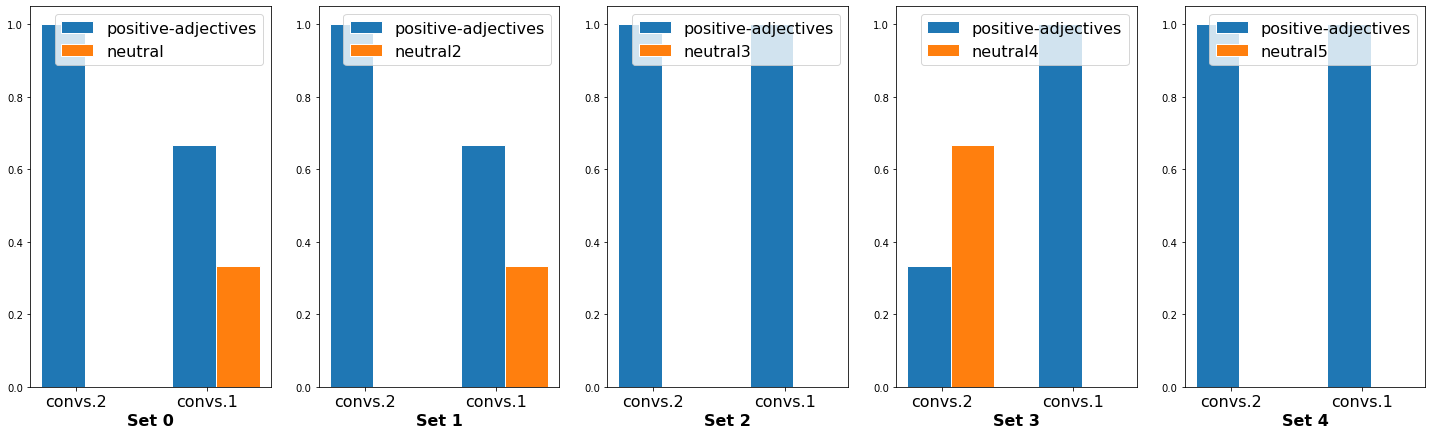

In [20]:
plot_tcav_scores(experimental_sets, positive_interpretations, ['convs.1', 'convs.2'], score_type='sign_count')

Now let's perform the same experiment for examples that have negative sentiment.

In [21]:
neg_input_texts = ["It was not a good movie pad", "I've never watched something as bad", \
    "It is a terrible movie ! pad"]
neg_input_text_indices = covert_text_to_tensor(neg_input_texts)


negative_interpretations = tcav.interpret(neg_input_text_indices, experimental_sets=experimental_sets)

Visualizing TCAV scores for sentances that have negative sentiment. As we can see from the digram below, TCAV score for `Positive Adjectives` is relatively low comapare to the opposite `Neutral` concept. This observation holds cosistently true accross all experimental sets and layers.

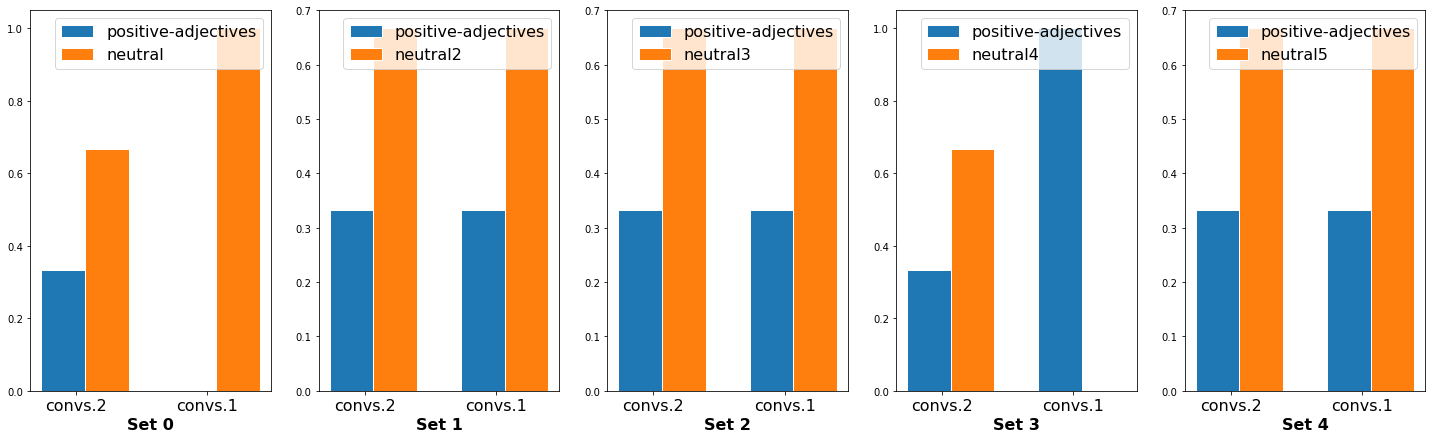

In [22]:
plot_tcav_scores(experimental_sets, negative_interpretations, ['convs.1', 'convs.2'], score_type='sign_count')

# Statistical significance testing of concepts

In order to convince ourselves that our concepts truly explain our predictions, we conduct statistical significance tests on TCAV scores by constructing a number of experimental sets. In this case we look into the `Positive Adjective` concept and a number of `Neutral` concepts. If `Positive Adjective` concept is truly important in predicting positive sentiment in the sentence, then we will see consistent high TCAV scores for `Positive Adjective` concept across all experimental sets as apposed to any other concept.

Each experimental set contains a random concept consisting of a number of random subsamples. In our case this allows us to estimate the robustness of TCAV scores by the means of numerous random concepts.



In addition, it is interesting to look into the p-values of statistical significance tests for each concept. We say, that we reject null hypothesis, if the p-value for concept's TCAV scores is smaller than 0.05. This indicates that the concept is important for model prediction.

We label concept populations as overlapping if p-value > 0.05 otherwise disjoint.



In [23]:
def get_pval(interpretations, layer, score_type, alpha=0.05, print_ret=False):
    P1 = extract_scores(interpretations, layer, score_type, 0)
    P2 =  extract_scores(interpretations, layer, score_type, 1)
    _, pval = ttest_ind(P1, P2)

    relation = "Disjoint" if pval < alpha else "Overlap"

    if print_ret:
        print('P1[mean, std]: ', format_float(np.mean(P1)), format_float(np.std(P1)))
        print('P2[mean, std]: ', format_float(np.mean(P2)), format_float(np.std(P2)))
        print("p-values:", format_float(pval))
        print(relation)
        
    return P1, P2, format_float(pval), relation


We can present the distribution of tcav scores using boxplots and the p-values indicating whether TCAV scores of those concepts are overlapping or disjoint.

In [24]:
def show_boxplots(layer, scores, metric='sign_count'):
    def format_label_text(experimental_sets):
        concept_name_list = [exp.name if i == 0 else \
                             exp.name.split('_')[0] for i, exp in enumerate(experimental_sets[0])]
        return concept_name_list

    n = 4
    fs = 18
    fig, ax = plt.subplots(1, 1, figsize = (20, 7 * 1))

    esl = experimental_sets[:]
    P1, P2, pval, relation = get_pval(scores, layer, metric)

    ax.set_ylim([0, 1])
    ax.set_title(layer + "-" + metric + " (pval=" + str(pval) + " - " + relation + ")", fontsize=fs)
    ax.boxplot([P1, P2], showfliers=True)

    ax.set_xticklabels(format_label_text(esl), fontsize=fs)

    plt.show()

The box plots below visualize the distribution of TCAV scores for a pair of concepts in two different layers, `convs.2` and `convs.1`. Each layer is visualized in a separate jupyter cell. Below diagrams show that `Positive Adjectives` concept has TCAV scores that are consistently high across all layers and experimental sets as apposed to `Neutral` concept. It also shows that `Positive Adjectives` and `Neutral` are disjoint populations.


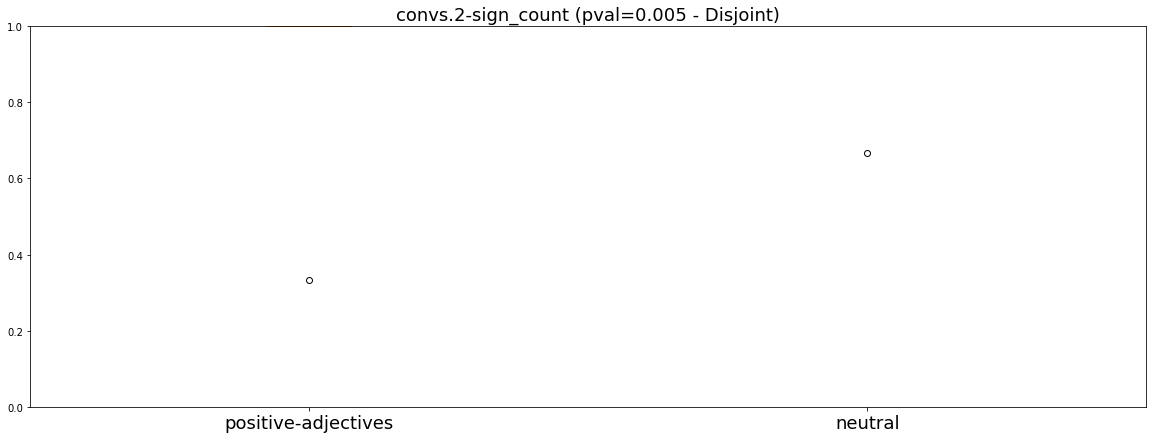

In [25]:
show_boxplots("convs.2", positive_interpretations, metric='sign_count')

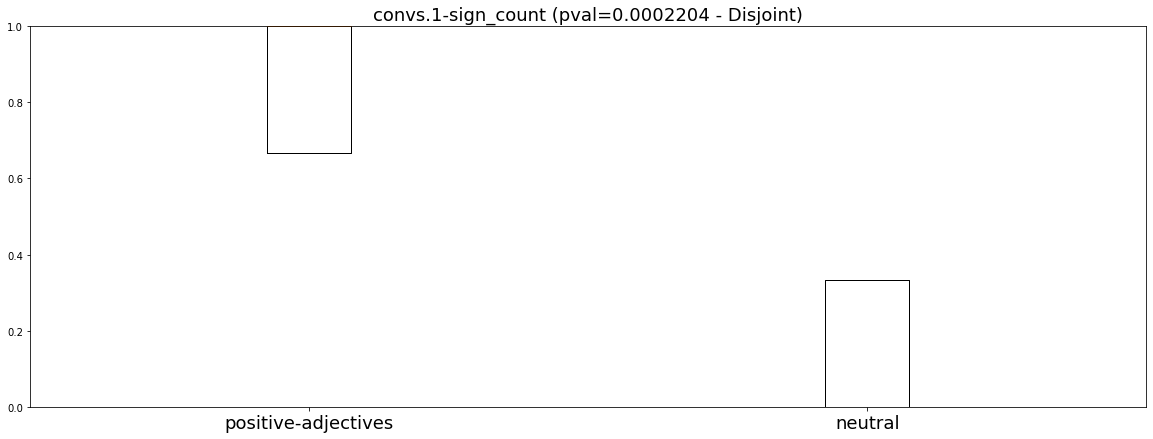

In [26]:
show_boxplots("convs.1", positive_interpretations, metric='sign_count')